In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import imutils
import pytesseract

import os

# 1. Read in Image, Grayscale and Blur

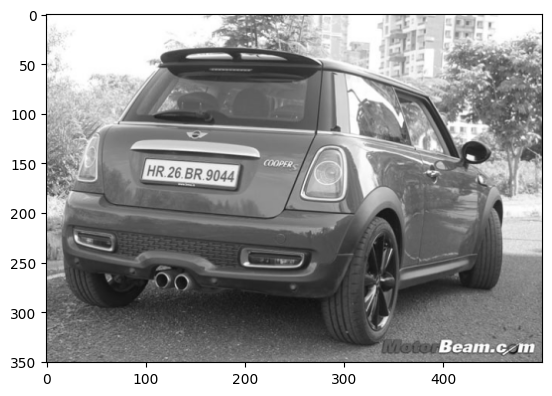

In [25]:
img = cv2.imread('example_data/image1.jpg')
img = imutils.resize(img, width=500)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

# 2. Apply filter and find edges for localization

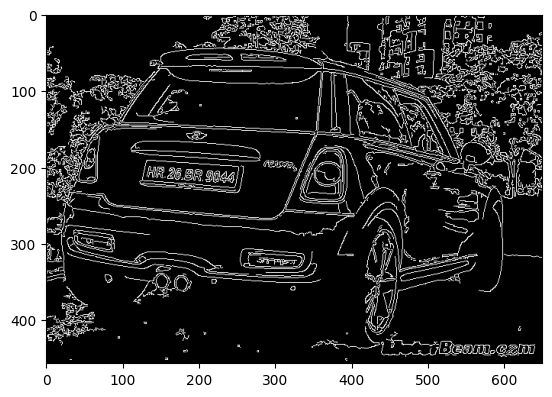

In [19]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) # Noise reduction
edged = cv2.Canny(bfilter, 30, 200) # Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

# 3. Find Contours and Apply Mask

In [20]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]

location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

location

array([[[122, 219]],

       [[246, 227]],

       [[252, 200]],

       [[132, 191]]], dtype=int32)

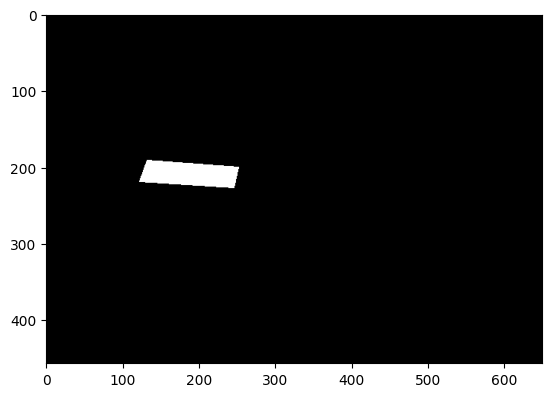

In [21]:
mask = np.zeros(gray.shape, np.uint8) # create a blank mask
new_image = cv2.drawContours(mask, [location], 0, 255, -1) # draw contours inside the mask image with location coordinates
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

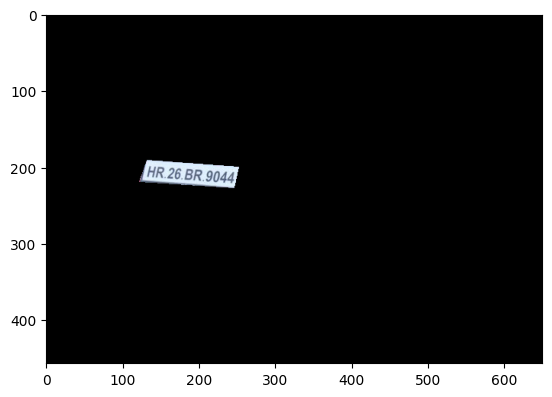

In [22]:
new_image = cv2.bitwise_and(img, img, mask=mask) # Applying masks on top of the original image
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

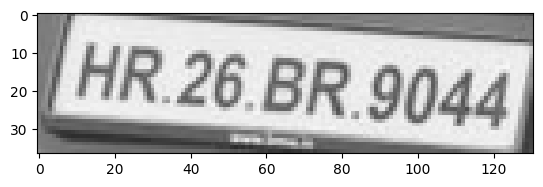

In [23]:
(x, y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2 + 1, y1:y2 + 1]

plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

# 4. Use Tesseract to Read Text

In [24]:
# converts the license plate characters to string
text = pytesseract.image_to_string(cropped_image, lang='eng')
print("License plate is:", text)

License plate is: [HR 26.BR 9044,



# 5. Compare Tesseract with other OCRs

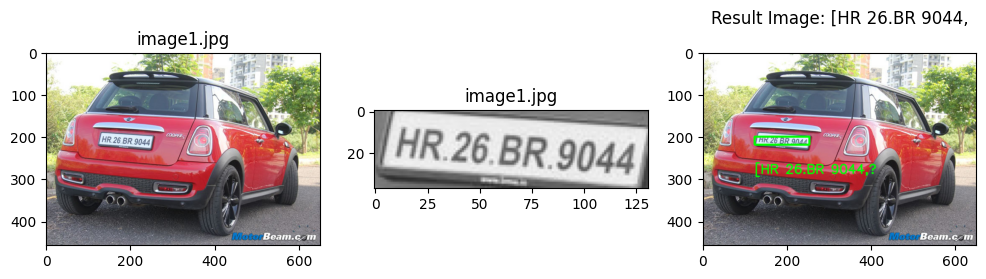

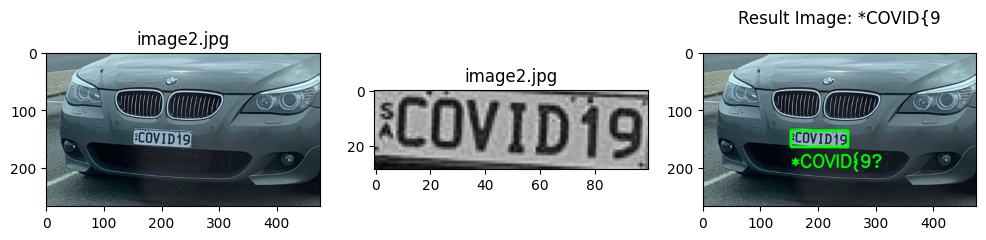

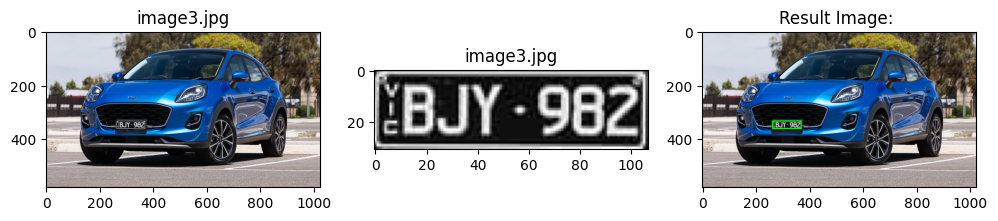

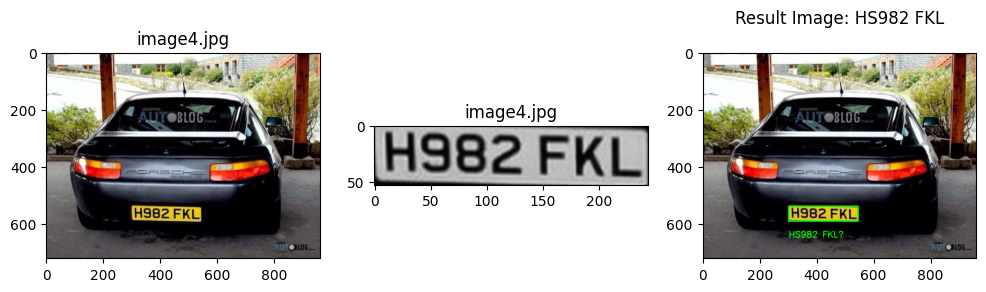

In [26]:
folder_path = 'example_data'
file_names = os.listdir(folder_path)

for file_name in file_names:
    img = cv2.imread(os.path.join(folder_path, file_name))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Make the image gray
    
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17) # Noise reduction
    edged = cv2.Canny(bfilter, 30, 200) # Edge detection
    
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # Find keypoints
    contours = imutils.grab_contours(keypoints) # Grab contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30] # Select the 30 largest contours 
    
    # Find the position of the license plate (rectangle search)
    location = None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            location = approx
            break
            
    # Extract the license plate from the original image
    mask = np.zeros(gray.shape, np.uint8) # create a blank mask
    new_image = cv2.drawContours(mask, [location], 0, 255, -1) # draw contours inside the mask image with location coordinates
    new_image = cv2.bitwise_and(img, img, mask=mask) # Applying masks on top of the original image
    (x, y) = np.where(mask==255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = gray[x1:x2 + 1, y1:y2 + 1]
    
    if location is None:
        print("\nLOCATION IS NONE!!!")
        break
    
    text = pytesseract.image_to_string(cropped_image, lang='eng')
    font = cv2.FONT_HERSHEY_SIMPLEX
    temp_img = img.copy()
    res = cv2.putText(temp_img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0, 255, 0), 
                 thickness=2, lineType=cv2.LINE_AA)
    res = cv2.rectangle(temp_img, tuple(approx[0][0]), tuple(approx[2][0]), (0, 255, 0), 3) # draw green rectangle
    
    # Create a figure with two subplots: one for the car image and one for the license plate image
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    # Display the car image on the left subplot
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title(file_name)

    # Display the license plate image in the middle subplot
    axes[1].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    axes[1].set_title(file_name)
    
     # Display the result image on the right subplot
    axes[2].imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f'Result Image: {text}')
    
    plt.show()  # Display the current image